In [4]:
!pip install scikit-learn
!pip install pandas
!pip install seaborn 
!pip install matplotlib
!pip install imblearn
!pip install numpy

In [2]:
import sklearn
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import glob
import re
from pathlib import Path
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

In [3]:
#convert the txt files to csv files
directories = ['heart_rate','motion','steps','labels']

for d in directories:
    for name in os.listdir(d):
        with open(os.path.join(d, name)) as f:
             file_path = os.path.join(d, name)
             dir_name = f"{d}_csv"
             os.makedirs(dir_name,exist_ok=True)
             df1 = pd.read_csv(file_path)
             csv_file_path = os.path.join(dir_name, f"{os.path.splitext(name)[0]}")
             df1.to_csv(csv_file_path + '.csv', 
                      index = None)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'heart_rate'

In [5]:
folders = ['steps_csv', 'heart_rate_csv', 'motion_csv']
df_prepared = []
for folder in folders:
    for name in os.listdir(folder):
            if not name.lower().endswith('.csv'):
                continue
            
            file_path = os.path.join(folder, name)
    
            if (folder == 'motion_csv'):
                df = pd.read_csv(file_path, header=None, sep=r'\s+')
            else:
                df = pd.read_csv(file_path, header=None)
                
            df_prepared.append((folder, name, df)) 


In [6]:
by_subject = defaultdict(dict)

for folder, name, df in df_prepared:
    sid = int(name.split("_", 1)[0])
    
    by_subject[sid][folder] = df


In [7]:

labels = {}

for path in glob.glob("labels_csv/*_labeled_sleep.csv"):
        sid = int(path.split("/")[-1].split("_",1)[0])
        df_lbl = pd.read_csv(path,sep=r'\s+')      
        # print("Shape:", df_lbl.shape)    
        # print("Columns:", df_lbl.columns.tolist())
        # print(df_lbl.head())
        # print(sid)
        # # df_lbl = pd.read_csv(path)
        df_lbl.columns = ["time","class"]
        labels[sid] = df_lbl

In [8]:
def aggregate_segments(df_stream, start, end, n_segments):
    seg_len = (end - start) / n_segments 
    seg_means = {}
    
    # Number of value columns 
    n_cols = df_stream.shape[1] - 1
    
    for j in range(n_segments):
        lo, hi = start + j*seg_len, start + (j+1)*seg_len
        
        # Boolean mask on the 'time' column (first column)
        mask = (df_stream.iloc[:, 0] >= lo) & (df_stream.iloc[:, 0] < hi)
        for i in range(1, n_cols + 1):
            vals = df_stream.loc[mask, df_stream.columns[i]]

        for i in range(1, n_cols+1):
            # select rows where mask is True, and the i-th column
            vals = df_stream.loc[mask, df_stream.columns[i]]
            
            feat_name = f"col{i}_seg{j+1}"
            seg_means[feat_name] = vals.mean()
    
    return seg_means


In [9]:
def build_subject_matrix(sid, by_subject, labels, n_segments):
    df_lbl = labels[sid]         
    rows   = []                 

    for start, cls in zip(df_lbl["time"], df_lbl["class"]):
        end = start + 30.0
        row = {
            "subject":       sid,
            "window_start":  start,
            "class":         cls
        }

        for stream_name, df_stream in by_subject[sid].items():
            seg_dict = aggregate_segments(df_stream, start, end, n_segments)
            for feat, val in seg_dict.items():
                row[f"{stream_name}_{feat}"] = val

        rows.append(row)

    return pd.DataFrame(rows)


In [10]:
def build_all_subjects(by_subject, labels, n_segments, out_csv):
    all_dfs = []
    for sid in sorted(labels.keys()):
            df_subj = build_subject_matrix(sid, by_subject, labels, n_segments)
            all_dfs.append(df_subj)
    
    full_df = pd.concat(all_dfs, axis=0, ignore_index=True)
    
    full_df.to_csv(out_csv, index=False)
    return full_df


In [11]:
out = "all_subjects_segmented.csv"
df_final = build_all_subjects(by_subject, labels, 5, out)
print(f"Saved {out} → shape {df_final.shape}")

Saved all_subjects_segmented.csv → shape (27180, 28)


In [5]:
df = pd.read_csv('all_subjects_segmented.csv')
df = df.drop(columns=["subject", "window_start"])
df = df[df['class'] != -1]

imputer = SimpleImputer(strategy='mean')
df_filled = imputer.fit_transform(df)

df_final = pd.DataFrame(df_filled)

df_final = df_final.fillna(0)
df_final.columns = df.columns

#df_final.iloc[0]

x = df_final.drop(columns=['class'])
y = df_final['class']

In [6]:
#outliers 
iso = IsolationForest(contamination=0.01, random_state=42)
mask = iso.fit_predict(x) == 1  # 1 = inlier
x = x[mask]
y = y[mask]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x, y)

#nomalization 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)           

C:\Users\amalf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\amalf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [7]:
print(df['class'].value_counts())

class
2    12954
5     5884
3     3329
0     2418
1     1821
4      356
Name: count, dtype: int64


Accuracy: 0.8876586376586376
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      2574
         1.0       0.90      0.94      0.92      2574
         2.0       0.73      0.70      0.72      2574
         3.0       0.90      0.93      0.91      2574
         4.0       0.97      1.00      0.98      2574
         5.0       0.90      0.87      0.89      2574

    accuracy                           0.89     15444
   macro avg       0.89      0.89      0.89     15444
weighted avg       0.89      0.89      0.89     15444



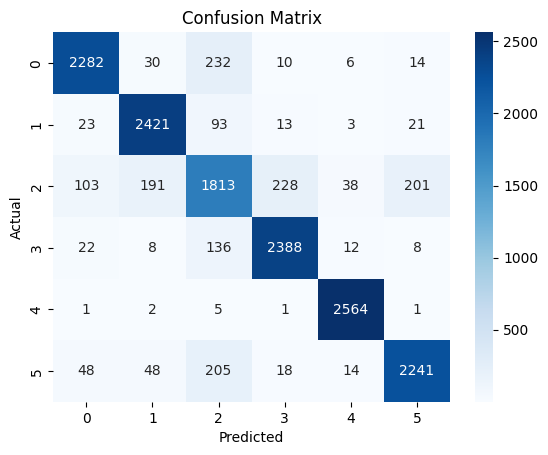

In [8]:
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

knn = KNeighborsClassifier(n_neighbors=2,weights='distance')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [9]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define multiple KNN models with different k values
knn2 = KNeighborsClassifier(n_neighbors=2, weights='distance', p=1)
knn5 = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
knn7 = KNeighborsClassifier(n_neighbors=7, weights='distance', p=1)
voting_knn = VotingClassifier(estimators=[('knn2', knn2), ('knn5', knn5), ('knn7', knn7)],voting='soft')


voting_knn.fit(X_train, y_train)
y_pred = voting_knn.predict(X_test)

print("Voting KNN Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Voting KNN Accuracy: 0.8936803936803936
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      2574
         1.0       0.89      0.93      0.91      2574
         2.0       0.75      0.75      0.75      2574
         3.0       0.91      0.94      0.92      2574
         4.0       0.96      1.00      0.98      2574
         5.0       0.92      0.87      0.89      2574

    accuracy                           0.89     15444
   macro avg       0.89      0.89      0.89     15444
weighted avg       0.89      0.89      0.89     15444



In [10]:
base_knn = KNeighborsClassifier(n_neighbors=2, weights='distance', p=1)

ensemble_knn = BaggingClassifier(
    estimator=base_knn,       
    n_estimators=30,
    max_samples=0.9,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

ensemble_knn.fit(X_train, y_train)

y_pred = ensemble_knn.predict(X_test)

print("Ensembled KNN Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Ensembled KNN Accuracy: 0.9109039109039109
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      2574
         1.0       0.91      0.93      0.92      2574
         2.0       0.90      0.74      0.81      2574
         3.0       0.92      0.94      0.93      2574
         4.0       0.97      1.00      0.98      2574
         5.0       0.92      0.89      0.90      2574

    accuracy                           0.91     15444
   macro avg       0.91      0.91      0.91     15444
weighted avg       0.91      0.91      0.91     15444



Voting Ensemble Accuracy: 0.9118751618751618
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      2574
         1.0       0.92      0.94      0.93      2574
         2.0       0.91      0.78      0.84      2574
         3.0       0.82      0.97      0.89      2574
         4.0       0.97      1.00      0.98      2574
         5.0       0.93      0.89      0.91      2574

    accuracy                           0.91     15444
   macro avg       0.91      0.91      0.91     15444
weighted avg       0.91      0.91      0.91     15444



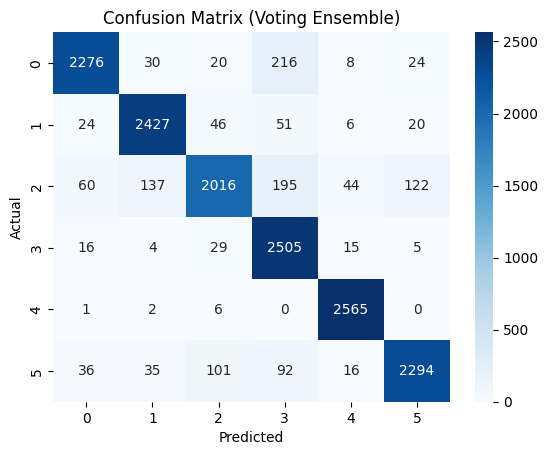

In [11]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=2, weights='distance', p=1)
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

ensemble = VotingClassifier( estimators=[ ('knn', knn), ('logreg', logreg), ('rf', rf) ],voting='soft')

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)

print("Voting Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Voting Ensemble)")
plt.show()


In [7]:
for k in range(1, 16):  
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, X_train, y_train, cv=20, scoring='accuracy')
    print(f"k={k}, Mean Accuracy: {np.mean(scores):.3f}")

k=1, Mean Accuracy: 0.819
k=2, Mean Accuracy: 0.819
k=3, Mean Accuracy: 0.803
k=4, Mean Accuracy: 0.806
k=5, Mean Accuracy: 0.791
k=6, Mean Accuracy: 0.795
k=7, Mean Accuracy: 0.789
k=8, Mean Accuracy: 0.786
k=9, Mean Accuracy: 0.781
k=10, Mean Accuracy: 0.777
k=11, Mean Accuracy: 0.773
k=12, Mean Accuracy: 0.770
k=13, Mean Accuracy: 0.767
k=14, Mean Accuracy: 0.758
k=15, Mean Accuracy: 0.754


In [27]:
print(y_train.value_counts())

class
1.0    10202
5.0    10202
0.0    10202
3.0    10201
2.0    10201
4.0    10201
Name: count, dtype: int64


Accuracy: 0.5300267921322617
              precision    recall  f1-score   support

         0.0       0.52      0.53      0.53      2550
         1.0       0.46      0.45      0.46      2550
         2.0       0.41      0.34      0.37      2551
         3.0       0.45      0.53      0.49      2551
         4.0       0.85      0.99      0.91      2551
         5.0       0.41      0.34      0.37      2550

    accuracy                           0.53     15303
   macro avg       0.52      0.53      0.52     15303
weighted avg       0.52      0.53      0.52     15303



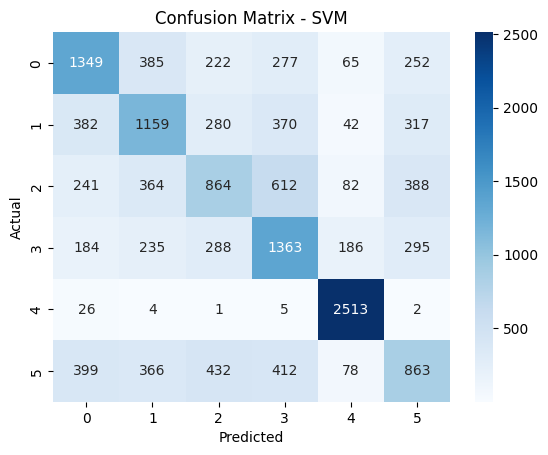

In [29]:
# Train SVM
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train, y_train)

# Predictions
y_pred = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()